# CIFAR10

## Objective

Training models to associate images representing common objects with their class (multiclass classification).

## Context

The [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes are completely mutually exclusive. There are 50,000 training images and 10,000 test images.

![CIFAR10 images](_images/cifar10.png)

## Instructions and advice

- Follow the main steps of a supervised ML project: data loading and exploring, data preparation, model training and evaluation.
- Use the [PyTorch](https://pytorch.org) library for data loading and model training. If you are new to it, consider following its [official tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html).
- Don't forget to setup your environment by importing the necessary Python packages. In particular, the [ainotes](https://github.com/bpesquet/ainotes) project contains several useful functions for [plotting](https://github.com/bpesquet/ainotes/blob/main/ainotes/utils/plot.py) and [training](https://github.com/bpesquet/ainotes/blob/main/ainotes/utils/train.py).
- Regarding data loading and preparation, bitmap images should be normalized. You can find an example using the CIFAR10 dataset [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#load-and-normalize-cifar10).
- You may train and evaluate a standard MultiLayer Perceptron, using [this chapter](../ann.ipynb) as a blueprint. Warning: you will have to adapt the inputs of your network to the color images of the CIFAR10 dataset.
- **Bonus**: train a convolutional neural network using [this chapter](../cnn.ipynb) as a blueprint. After training, compare its performance with the MLP results.

## Environment setup

In [20]:
# pylint: disable=wrong-import-position

import os

# Installing the ainotes package is only necessary in standalone runtime environments like Colab
if os.getenv("COLAB_RELEASE_TAG"):
    print("Standalone runtime environment detected, installing ainotes package")
    %pip install ainotes

# pylint: enable=wrong-import-position

In [21]:
import platform

import numpy as np
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from ainotes.utils.plot import plot_loss_acc, plot_cifar10_images
from ainotes.utils.train import get_device, count_parameters, fit

In [22]:
# Setup plots

# Include matplotlib graphs into the notebook, next to the code
# https://stackoverflow.com/a/43028034/2380880
%matplotlib inline

# Improve plot quality
%config InlineBackend.figure_format = "retina"

# Setup seaborn default theme
# http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
sns.set_theme()

In [23]:
# Print environment info
print(f"Python version: {platform.python_version()}")
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")


# PyTorch device configuration
device, message = get_device()
print(message)

Python version: 3.11.1
NumPy version: 1.26.4
PyTorch version: 2.2.1
Using MPS GPU :)


## Data loading and exploring

In [24]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # Dataset contains PIL images of range [0, 1]
        # We transform them to Tensors of normalized range [-1, 1]
        # https://stackoverflow.com/a/65679179
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

cifar_train_data = datasets.CIFAR10(
    root="data", train=True, download=True, transform=transform
)

cifar_test_data = datasets.CIFAR10(
    root="data", train=False, download=True, transform=transform
)

cifar_labels = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
cifar_img, cifar_label = cifar_train_data[0]

print(f"First image: {cifar_img.shape}. Label: {cifar_label}")

# Unnormalize pixel values
pixel_values = (cifar_img[:, 0, 0] / 2 + 0.5) * 255
print(f"RGB values of first pixel: {pixel_values.int()}")

First image: torch.Size([3, 32, 32]). Label: 6
RGB values of first pixel: tensor([58, 61, 62], dtype=torch.int32)


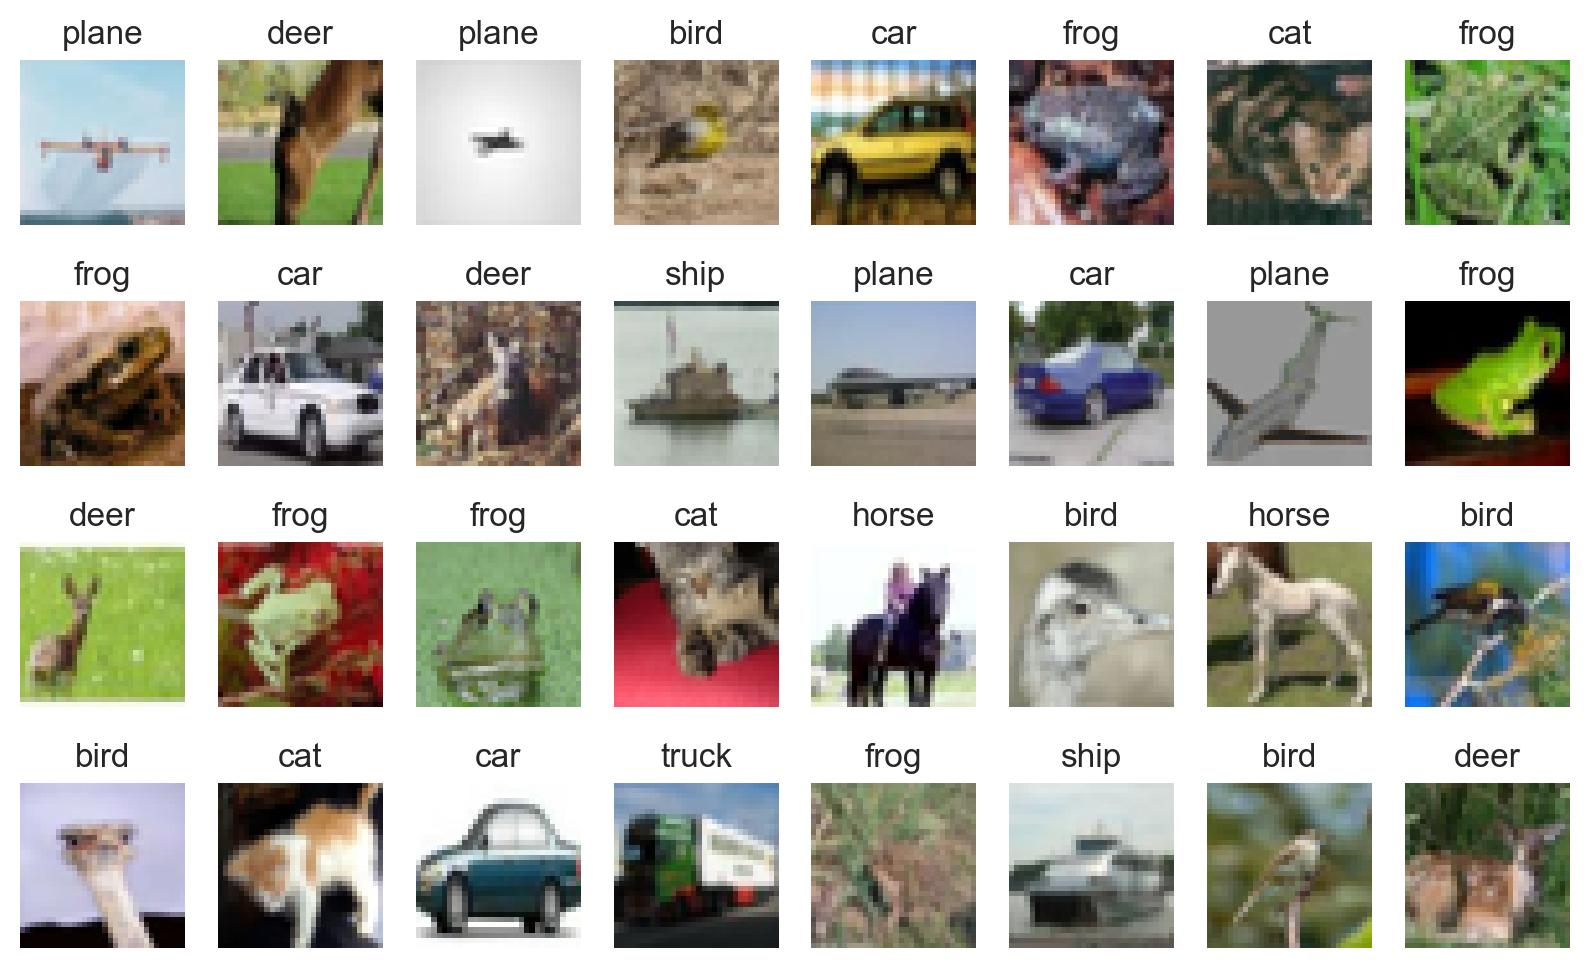

In [26]:
# Plot some of the training images
plot_cifar10_images(data=cifar_train_data, labels=cifar_labels, device=device)

## Hyperparameters

In [27]:
# Hyperparameters
learning_rate = 1e-3
n_epochs = 10
batch_size = 64

## Data preparation

In [28]:
cifar_train_dataloader = DataLoader(cifar_train_data, batch_size=batch_size)
cifar_test_dataloader = DataLoader(cifar_test_data, batch_size=batch_size)

## Training a MLP

### Model definition

In [29]:
class NeuralNetwork(nn.Module):
    """Neural network for CIFAR images classification"""

    def __init__(self):
        super().__init__()

        # Flatten the input image of shape (3, 32, 32) into a vector of shape (3*32*32,)
        self.flatten = nn.Flatten()

        # Define a sequential stack of linear layers and activation functions
        self.layer_stack = nn.Sequential(
            # First hidden layer with 3072 inputs
            nn.Linear(in_features=3 * 32 * 32, out_features=64),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            # Output layer
            nn.Linear(in_features=64, out_features=10),
        )

    def forward(self, x):
        """Define the forward pass of the model"""

        # Apply flattening to input
        x = self.flatten(x)

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits

In [30]:
cifar_mlp = NeuralNetwork().to(device)
print(cifar_mlp)

# Try to guess the total number of parameters for this model before running this code!
print(f"Number of trainable parameters: {count_parameters(cifar_mlp)}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Number of trainable parameters: 201482


### Model training

In [31]:
cifar_mlp_history = fit(
    dataloader=cifar_train_dataloader,
    model=cifar_mlp,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(cifar_mlp.parameters(), lr=learning_rate),
    epochs=n_epochs,
    device=device,
)

Training started! 50000 samples. 782 batches per epoch


100%|███████████████████████████████████████████████████████| 782/782 [00:07<00:00, 110.23batches/s]


Epoch [  1/ 10] finished. Mean loss: 1.66641. Accuracy: 42.50%


100%|███████████████████████████████████████████████████████| 782/782 [00:06<00:00, 111.92batches/s]


Epoch [  2/ 10] finished. Mean loss: 1.47174. Accuracy: 49.56%


100%|███████████████████████████████████████████████████████| 782/782 [00:06<00:00, 112.00batches/s]


Epoch [  3/ 10] finished. Mean loss: 1.38659. Accuracy: 52.65%


100%|███████████████████████████████████████████████████████| 782/782 [00:07<00:00, 110.82batches/s]


Epoch [  4/ 10] finished. Mean loss: 1.32580. Accuracy: 54.83%


100%|███████████████████████████████████████████████████████| 782/782 [00:06<00:00, 112.45batches/s]


Epoch [  5/ 10] finished. Mean loss: 1.27944. Accuracy: 56.55%


100%|███████████████████████████████████████████████████████| 782/782 [00:06<00:00, 111.77batches/s]


Epoch [  6/ 10] finished. Mean loss: 1.23932. Accuracy: 58.09%


100%|███████████████████████████████████████████████████████| 782/782 [00:06<00:00, 113.24batches/s]


Epoch [  7/ 10] finished. Mean loss: 1.20485. Accuracy: 59.44%


100%|███████████████████████████████████████████████████████| 782/782 [00:06<00:00, 112.84batches/s]


Epoch [  8/ 10] finished. Mean loss: 1.17425. Accuracy: 60.53%


100%|███████████████████████████████████████████████████████| 782/782 [00:07<00:00, 111.39batches/s]


Epoch [  9/ 10] finished. Mean loss: 1.14684. Accuracy: 61.48%


100%|███████████████████████████████████████████████████████| 782/782 [00:06<00:00, 111.81batches/s]

Epoch [ 10/ 10] finished. Mean loss: 1.12274. Accuracy: 62.40%
Training complete! Total gradient descent steps: 7820


### Training results

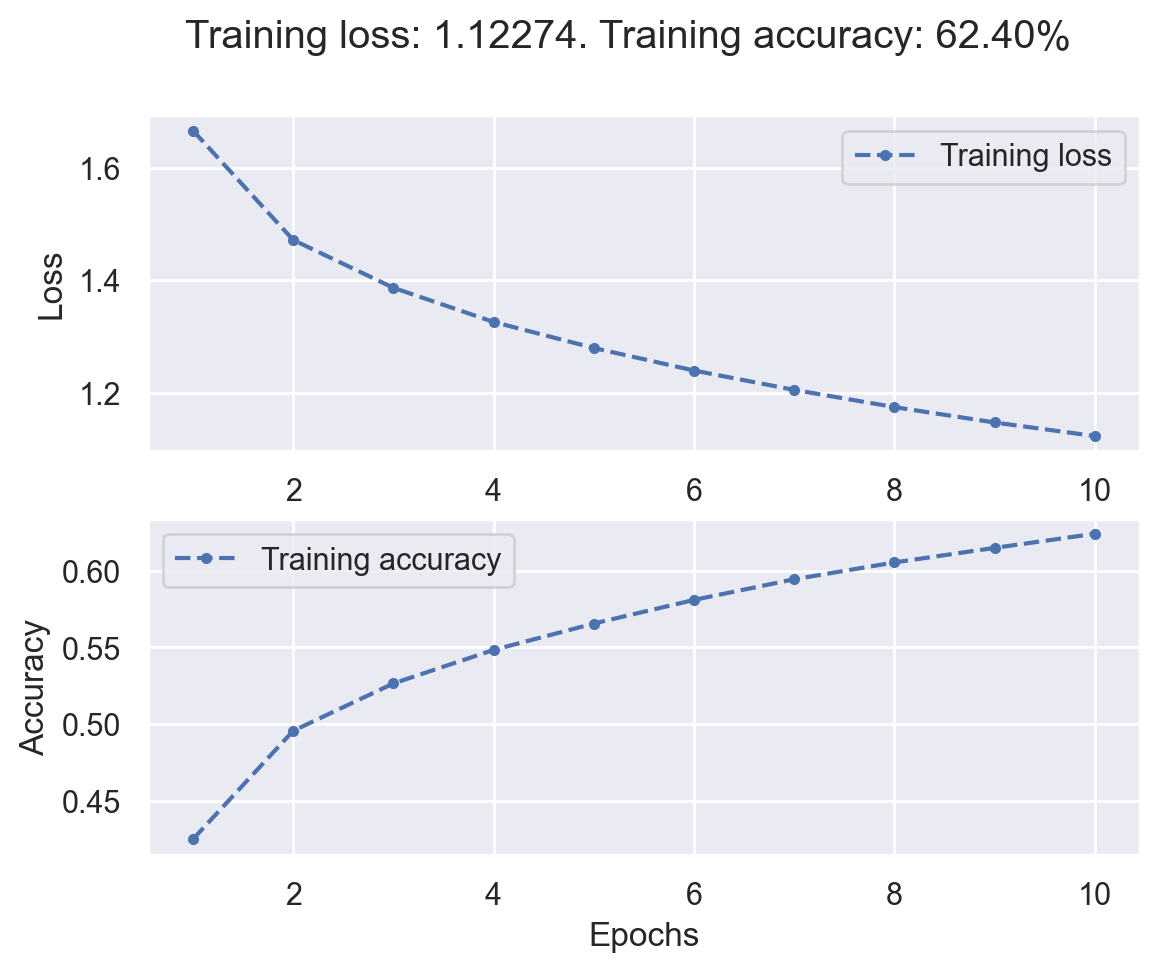

In [32]:
# Plot training history
plot_loss_acc(cifar_mlp_history)

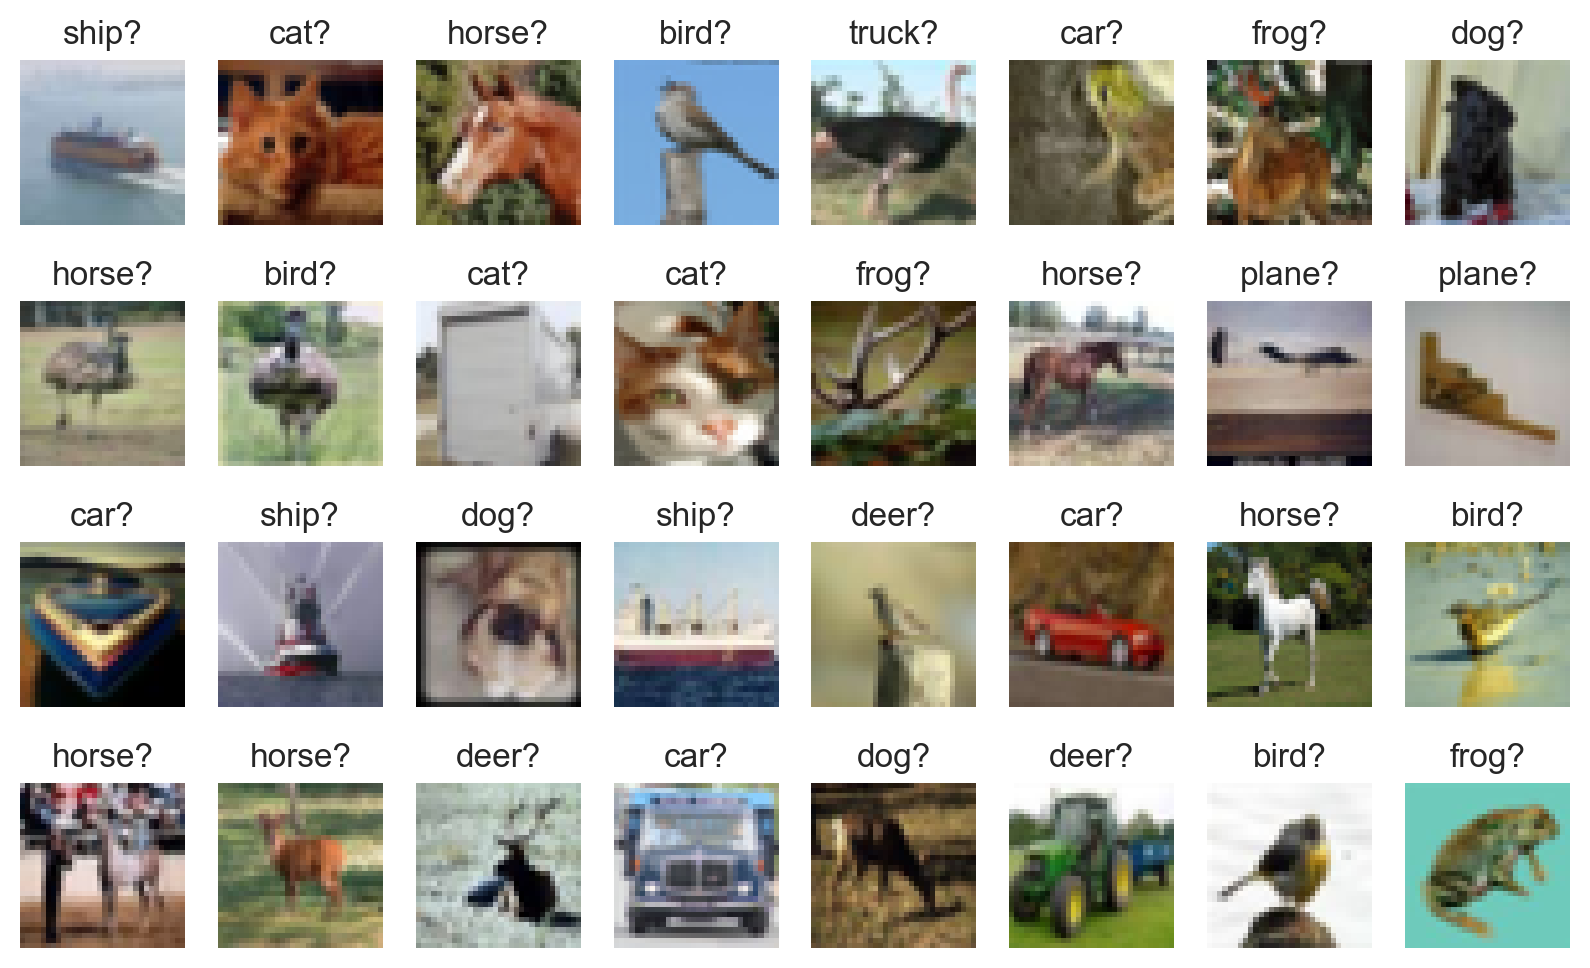

In [33]:
# Show model predictions on some test images
plot_cifar10_images(
    data=cifar_train_data, labels=cifar_labels, device=device, model=cifar_mlp
)

### Results interpretation

Although training smoothly, the MLP model incorrectly classifies more than 1/3 of the training data. Its architecture is too limited for this non-trivial task.

## Training a convnet

### Model definition

In [34]:
class Convnet(nn.Module):
    """Convnet for CIFAR image classification"""

    def __init__(self):
        super().__init__()

        # Define a sequential stack
        self.layer_stack = nn.Sequential(
            # Feature extraction part, with convolutional and pooling layers
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Classification part, with fully connected layers
            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        """Define the forward pass of the model"""

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits

In [35]:
cifar_convnet = Convnet().to(device)
print(cifar_convnet)

# Try to guess the total number of parameters for this model before running this code!
print(f"Number of trainable parameters: {count_parameters(cifar_convnet)}")

Convnet(
  (layer_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)
Number of trainable parameters: 315722


### Model training

In [36]:
cifar_convnet_history = fit(
    dataloader=cifar_train_dataloader,
    model=cifar_convnet,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(cifar_convnet.parameters(), lr=learning_rate),
    epochs=n_epochs,
    device=device,
)

Training started! 50000 samples. 782 batches per epoch


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 83.50batches/s]


Epoch [  1/ 10] finished. Mean loss: 1.43456. Accuracy: 49.84%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 84.25batches/s]


Epoch [  2/ 10] finished. Mean loss: 1.06703. Accuracy: 63.99%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 84.33batches/s]


Epoch [  3/ 10] finished. Mean loss: 0.91210. Accuracy: 69.72%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 84.36batches/s]


Epoch [  4/ 10] finished. Mean loss: 0.80453. Accuracy: 73.73%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 82.74batches/s]


Epoch [  5/ 10] finished. Mean loss: 0.71449. Accuracy: 77.07%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 83.82batches/s]


Epoch [  6/ 10] finished. Mean loss: 0.63657. Accuracy: 80.04%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 83.70batches/s]


Epoch [  7/ 10] finished. Mean loss: 0.56749. Accuracy: 82.69%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 83.60batches/s]


Epoch [  8/ 10] finished. Mean loss: 0.50548. Accuracy: 85.04%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 83.99batches/s]


Epoch [  9/ 10] finished. Mean loss: 0.45347. Accuracy: 86.96%


100%|████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 84.04batches/s]

Epoch [ 10/ 10] finished. Mean loss: 0.40707. Accuracy: 88.85%
Training complete! Total gradient descent steps: 7820


### Training results

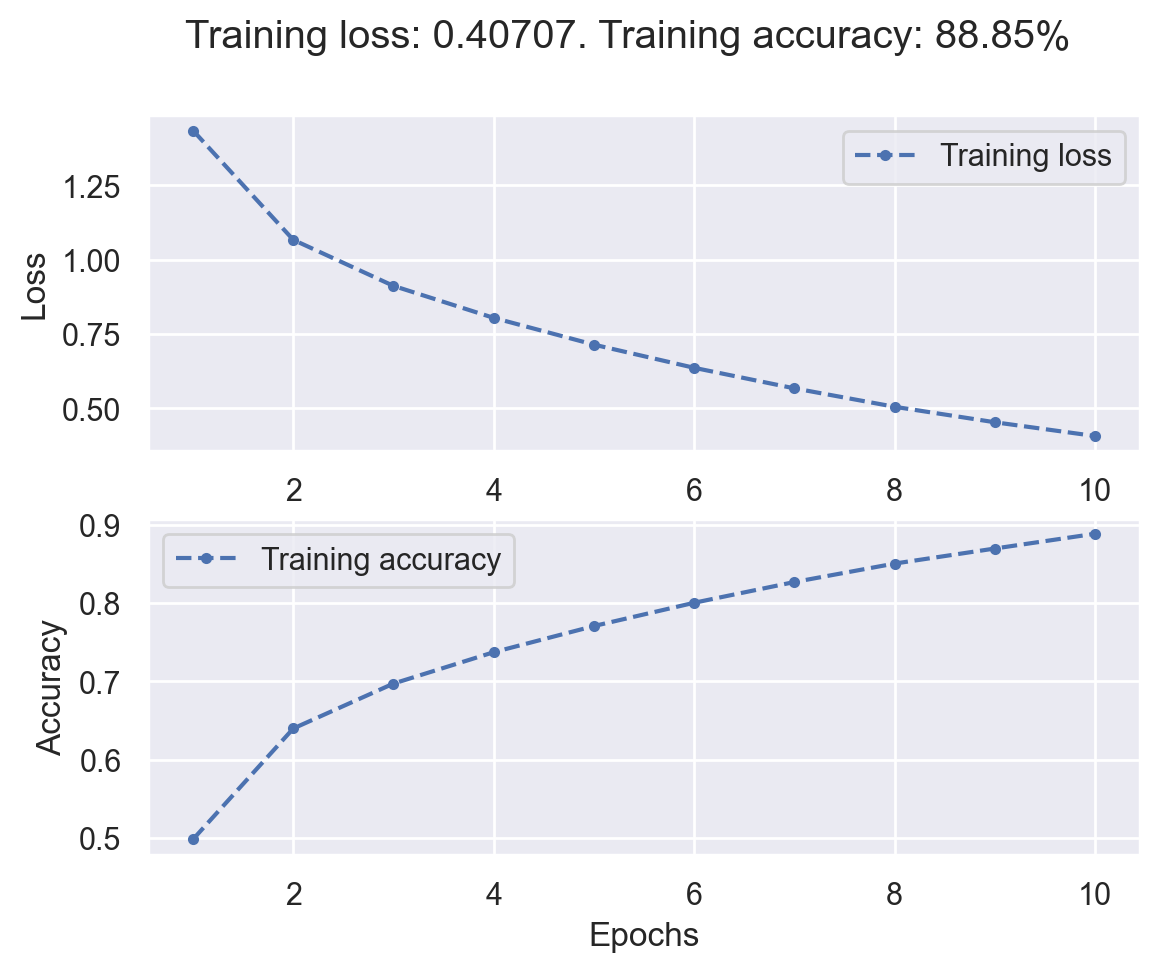

In [37]:
# Plot training history
plot_loss_acc(cifar_convnet_history)

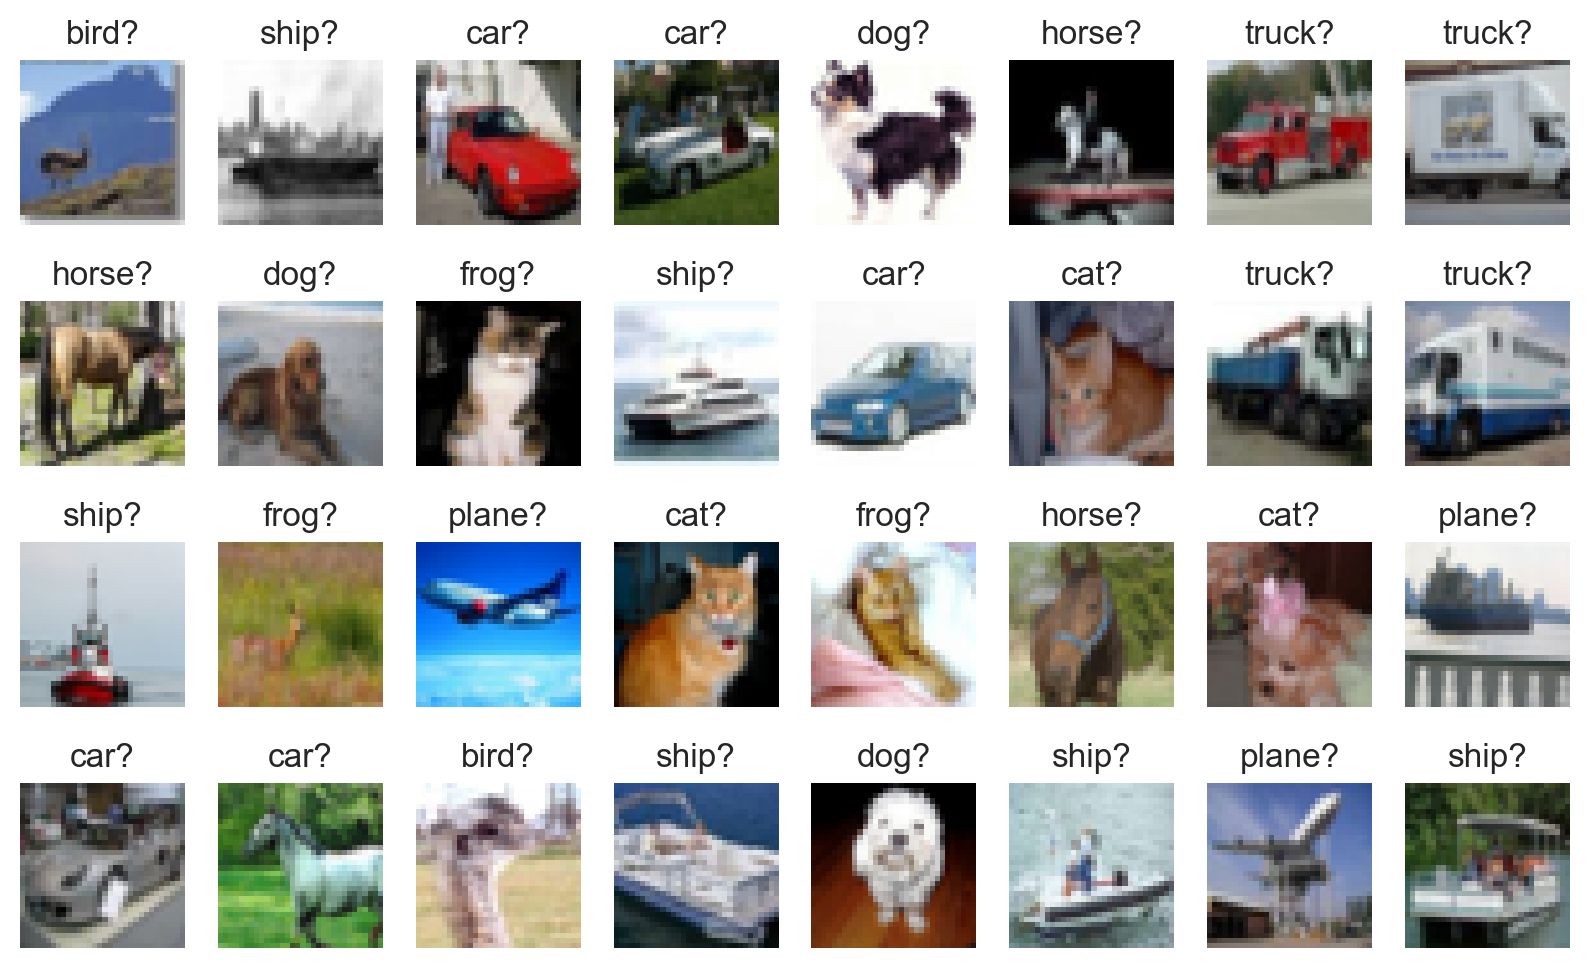

In [38]:
# Show model predictions on some test images
plot_cifar10_images(
    data=cifar_train_data, labels=cifar_labels, device=device, model=cifar_convnet
)

### Results interpretation

The convnet is much better than the MLP at classifying CIFAR10 images, which is not surprising given that its architecture was invented for this kind of task.

Results could probably be even better with a longer training time.